In [40]:
import pandas as pd
import numpy as np
import geopandas as gpd

   OBJECTID         NAME    SHAPE_LENG  \
0       248         None  10436.913657   
1       247  Chindwin R.  12140.226547   
2       245         None  25863.663641   
3       246         None   7868.889000   
4       244         None   8950.168611   

                                            geometry  
0  LINESTRING (94.633 24.147, 94.644 24.139, 94.6...  
1  LINESTRING (94.681 24.161, 94.685 24.155, 94.6...  
2  LINESTRING (94.776 24.264, 94.779 24.26, 94.78...  
3  LINESTRING (94.681 24.203, 94.667 24.212, 94.6...  
4  LINESTRING (94.828 24.297, 94.838 24.3, 94.842...  
Index(['OBJECTID', 'NAME', 'SHAPE_LENG', 'geometry'], dtype='object')
EPSG:4326


<Axes: >

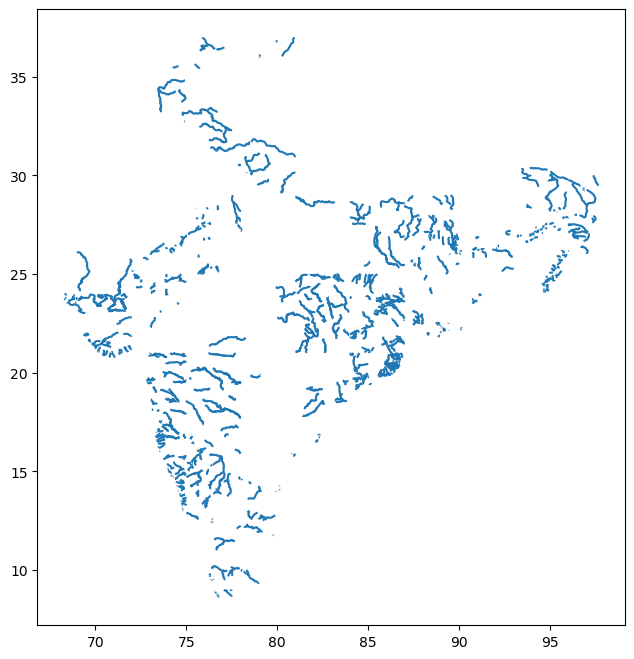

In [41]:
gdf = gpd.read_file("..\data\Rivers\RIVER_2M.shp")

print(gdf.head())
print(gdf.columns)
print(gdf.crs)

gdf.plot(figsize=(10, 8))


In [42]:
states = gpd.read_file("..\data\Soil Profiles\india_states\gadm41_IND_1.json").to_crs("EPSG:4326")
gdf = gdf.to_crs(states.crs)

print("Geology CRS:", gdf.crs)
print("States CRS:", states.crs)

Geology CRS: EPSG:4326
States CRS: EPSG:4326


In [43]:
gdf_states = gpd.sjoin(gdf, states, how="inner", predicate="intersects")

print(gdf_states.head())
print(gdf_states.columns)

    OBJECTID            NAME    SHAPE_LENG  \
40       261            None   6413.411270   
43       262            None  11797.254388   
44       264  Brahmaputra R.  23772.493214   
44       264  Brahmaputra R.  23772.493214   
45       270            None  15223.530879   

                                             geometry  index_right    GID_1  \
40  LINESTRING (94.542 27.071, 94.55 27.071, 94.55...            4  IND.4_1   
43  LINESTRING (94.749 27.276, 94.759 27.288, 94.7...            4  IND.4_1   
44  LINESTRING (95.422 27.258, 95.429 27.254, 95.4...            4  IND.4_1   
44  LINESTRING (95.422 27.258, 95.429 27.254, 95.4...            2  IND.3_1   
45  LINESTRING (94.618 27.338, 94.618 27.342, 94.6...            4  IND.4_1   

   GID_0 COUNTRY            NAME_1                    VARNAME_1 NL_NAME_1  \
40   IND   India             Assam                           NA        NA   
43   IND   India             Assam                           NA        NA   
44   IND   India 

In [44]:
rivers_state = gdf_states.to_crs(epsg=7755)

# compute length in km (not area)
rivers_state["rivers_length_km"] = rivers_state.geometry.length / 1000
print(rivers_state[["NAME_1", "rivers_length_km"]].head(30))

              NAME_1  rivers_length_km
40             Assam          6.055572
43             Assam         11.128021
44             Assam         22.428284
44  ArunachalPradesh         22.428284
45             Assam         14.354218
46  ArunachalPradesh        125.155364
48             Assam         10.934559
50             Assam         15.035524
51             Assam         25.136103
52  ArunachalPradesh         12.709982
53  ArunachalPradesh         18.492757
54  ArunachalPradesh          7.824421
56             Assam         16.212339
57             Assam         14.077876
57  ArunachalPradesh         14.077876
58  ArunachalPradesh          5.821696
60  ArunachalPradesh        260.767026
60  ArunachalPradesh        260.767026
61  ArunachalPradesh          9.340765
62  ArunachalPradesh          8.615720
63  ArunachalPradesh          2.070977
64  ArunachalPradesh        318.823688
65  ArunachalPradesh         10.927641
66  ArunachalPradesh         17.223715
67  ArunachalPradesh     

In [45]:
states_ae = states.to_crs(7755).copy()
states_ae["geometry"] = states_ae.buffer(0)
key = "GID_1" if "GID_1" in states_ae.columns else "NAME_1"
states_diss = states_ae.dissolve(by=key, as_index=False)
states_diss["state_area_km2"] = states_diss.geometry.area / 1e6
if key != "NAME_1" and "NAME_1" in states.columns:
    name_lookup = states[[key, "NAME_1"]].drop_duplicates(subset=[key])
    states_diss = states_diss.merge(name_lookup, on=key, how="left")

if "NAME_1_x" in states_diss.columns or "NAME_1_y" in states_diss.columns:
    states_diss["NAME_1"] = states_diss[["NAME_1_x","NAME_1_y"]].bfill(axis=1).iloc[:,0]
    states_diss = states_diss.drop(columns=[c for c in ["NAME_1_x","NAME_1_y"] if c in states_diss.columns])

print(states_diss.columns)
print(states_diss[["NAME_1", "state_area_km2"]].head(30))
print(states_diss['NAME_1'].nunique())


Index(['GID_1', 'geometry', 'GID_0', 'COUNTRY', 'VARNAME_1', 'NL_NAME_1',
       'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1', 'state_area_km2',
       'NAME_1'],
      dtype='object')
               NAME_1  state_area_km2
0                 Goa     3632.983233
1             Gujarat   178710.963855
2             Haryana    42687.189733
3     HimachalPradesh    54113.608169
4           Jharkhand    76969.064288
5           Karnataka   188950.305479
6              Kerala    38278.248532
7         Lakshadweep       34.410229
8       MadhyaPradesh   296337.425697
9   AndamanandNicobar     7686.667479
10        Maharashtra   297503.811677
11            Manipur    21466.145561
12          Meghalaya    21664.267559
13            Mizoram    20437.907210
14           Nagaland    15980.569133
15         NCTofDelhi     1453.883590
16             Odisha   150235.179349
17         Puducherry      549.097177
18             Punjab    49000.017202
19          Rajasthan   329596.284124
20      Andhr

In [46]:
river_len_by_state = (
    rivers_state.groupby("NAME_1", as_index=False)["rivers_length_km"]
    .sum()
    .rename(columns={"rivers_length_km":"river_length_km"})
)

# ensure one row per state with area
area_by_state = states_diss[["NAME_1","state_area_km2"]].drop_duplicates(subset=["NAME_1"])

# merge and compute drainage density
river_density = river_len_by_state.merge(area_by_state, on="NAME_1", how="right")
river_density["river_length_km"] = river_density["river_length_km"].fillna(0)
river_density["drainage_density_km_per_km2"] = river_density["river_length_km"] / river_density["state_area_km2"]

print(river_density.sort_values("drainage_density_km_per_km2", ascending=False).head(20))

              NAME_1  river_length_km  state_area_km2  \
28  ArunachalPradesh      1334.206664    14350.350432   
0                Goa       190.773912     3632.983233   
21            Sikkim       260.817569     6837.193132   
27        WestBengal      2424.603891    82132.414279   
16            Odisha      4299.605675   150235.179349   
4          Jharkhand      2130.699957    76969.064288   
3    HimachalPradesh      1225.164732    54113.608169   
32      Chhattisgarh      2805.292027   130608.945230   
5          Karnataka      3613.075809   188950.305479   
1            Gujarat      3410.881513   178710.963855   
30             Bihar      1565.571567    90692.293902   
10       Maharashtra      4581.888035   297503.811677   
17        Puducherry         8.192903      549.097177   
26       Uttarakhand       690.007507    51141.250467   
29             Assam      1004.520154    75605.994331   
6             Kerala       421.198179    38278.248532   
20     AndhraPradesh      1420.

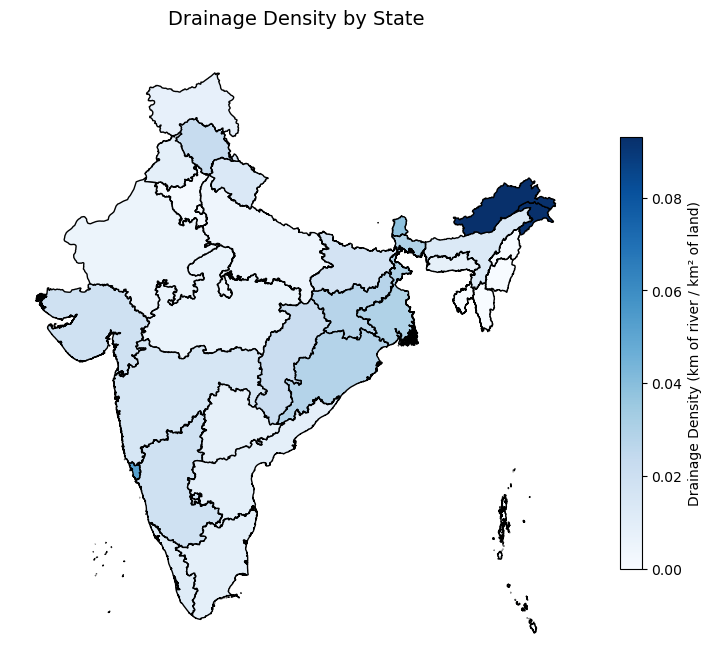

In [47]:
ax = states_dd.plot(
    column="drainage_density_km_per_km2",
    legend=True,
    figsize=(10,8),
    cmap="Blues",
    edgecolor="black",
    legend_kwds={
        "label": "Drainage Density (km of river / km² of land)",
        "orientation": "vertical",
        "shrink": 0.7,
    }
)

ax.set_title("Drainage Density by State", fontsize=14, pad=15)
ax.set_axis_off()


In [48]:
states_dd[["NAME_1","state_area_km2","drainage_density_km_per_km2"]].to_csv("../data/drainage_density_per_state.csv", index=False)